In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp

In [332]:
df = pd.read_csv('T1_A24census0.csv')

In [333]:
df.head()

,House Number,Street,First Name,Surname,Age,Relationship to Head of House,Marital Status,Gender,Occupation,Infirmity,Religion
0,1,Blue Avenue,Annette,Thompson,78,Head,Married,Female,Retired Licensed conveyancer,NaN,Christian
1,1,Blue Avenue,Iain,Thompson,79,Husband,Married,Male,"Retired Engineer, technical sales",NaN,No Religion
2,2,Blue Avenue,Angela,Wright,43,Head,Single,Female,Magazine journalist,NaN,No Religion
3,3,Blue Avenue,Lynda,Ahmed,34,Head,Married,Female,Unemployed,NaN,No Religion
4,3,Blue Avenue,Howard,Ahmed,35,Husband,Married,Male,Analytical chemist,NaN,No Religion


## Exploratory Analysis
### Checking for count. duplicates, missing values, inconsistencies etc.

In [334]:
df.count()

House Number                     8568
Street                           8568
First Name                       8568
Surname                          8559
Age                              8568
Relationship to Head of House    7905
Marital Status                   6544
Gender                           8568
Occupation                       8568
Infirmity                          95
Religion                         7529
dtype: int64

In [335]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8568 entries, 0 to 8567
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   House Number                   8568 non-null   int64 
 1   Street                         8568 non-null   object
 2   First Name                     8568 non-null   object
 3   Surname                        8559 non-null   object
 4   Age                            8568 non-null   int64 
 5   Relationship to Head of House  7905 non-null   object
 6   Marital Status                 6544 non-null   object
 7   Gender                         8568 non-null   object
 8   Occupation                     8568 non-null   object
 9   Infirmity                      95 non-null     object
 10  Religion                       7529 non-null   object
dtypes: int64(2), object(9)
memory usage: 736.4+ KB


In [336]:
df.isna().sum()

House Number                        0
Street                              0
First Name                          0
Surname                             9
Age                                 0
Relationship to Head of House     663
Marital Status                   2024
Gender                              0
Occupation                          0
Infirmity                        8473
Religion                         1039
dtype: int64

In [337]:
df.duplicated().sum()

np.int64(0)

In [338]:
relationship = df['Relationship to Head of House']

In [339]:
Occupation = df['Occupation']

In [340]:
relationship.unique()

array(['Head', 'Husband', 'Daughter', 'Lodger', 'Grandson', 'Son', nan,
       'Wife', 'Granddaughter', 'Partner', 'Niece', 'Visitor', 'Sibling',
       'Adopted Son', 'Cousin', 'Nephew', 'Adopted Daughter',
       'Step-Daughter', 'Step-Son', 'Adopted Granddaughter',
       'Daughter-in-law'], dtype=object)

In [341]:
for i in Occupation.unique():
    if i == 'Unemployed':
        print(i)


Unemployed


## FILLING MISSING VALUES IN SURNAME COLUMN
### This is done by grouping the data by similar house number and street name and filling the columns with missing values with the most frequent surname of that group

In [342]:
df['Surname'].replace('', pd.NA)
df['Surname'] = df.groupby(['House Number', 'Street'])['Surname'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else pd.NA))

## CLEANING THE RELIGION COLUMN
### Using the format of the 2021 census, the religions stated were, Christain, Muslim, No Religion, Hindu and Others with "Others" representing other religions. With this Knowledge, we would be cleaning our data as follows.

In [343]:
#filling the missing religion columns with the most frequent religion in the household
df['Religion'].replace('', pd.NA)
df['Religion'] = df.groupby(['House Number', 'Street'])['Religion'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else pd.NA))

In [344]:

# Define a mapping for major religions
religion_mapping = {
    'Christian': 'Christian',
    'Muslim': 'Muslim',
    'No religion': 'No religion',
    'Hindu': 'Hindu'
}

# Applying the mapping to classify the 'Religion' column
df['Religion'] = df['Religion'].apply(lambda x: religion_mapping.get(x, 'Other'))



## CLEANING THE RELATTIONSHIP TO HEAD OF HOUSE COLUMN
### The codes first groups the data into age groups based on their ages and then addresses missing values in the 'Relationship to Head of House' column by categorizing individuals into using  other demographic information as well as theri probabilities to fill the missing values.

In [345]:
def categorize_age(age):
    if age <= 17:
        return 'Teenager'
    elif 18 <= age <= 25:
        return 'Young Adult'
    elif 26 <= age <= 50:
        return 'Adult'
    else:
        return 'Old'

df['Age Group'] = df['Age'].apply(categorize_age)

In [346]:
# Calculates the proportion of marital statuses for missing 'Relationship to Head of House'
df[df['Relationship to Head of House'].isna()]['Marital Status'].value_counts(normalize=True)

# Create age groups
df.loc[df['Age'] <= 17, 'Age Group'] = 'Teenager'
df.loc[df['Age'].between(18, 25), 'Age Group'] = 'Young Adult'
df.loc[df['Age'].between(26, 50), 'Age Group'] = 'Adult'
df.loc[df['Age'] > 50, 'Age Group'] = 'Old'

# this Analyzes age groups for missing 'Relationship to Head of House'
df[df['Relationship to Head of House'].isna()]['Age Group'].value_counts(normalize=True)

# this Fills missing values based on age, gender, and marital status

# For Young Adult and Adult single females
mask = (df['Age Group'].isin(['Young Adult', 'Adult'])) & (df['Gender'] == 'Female') & (df['Marital Status'] == 'Single')
df.loc[mask, 'Relationship to Head of House'] = df.loc[mask, 'Relationship to Head of House'].fillna(random.choices(['Head', 'Daughter', 'Lodger'], weights=[4, 3, 1])[0])

# For Young Adult and Adult single males
mask = (df['Age Group'].isin(['Young Adult', 'Adult'])) & (df['Gender'] == 'Male') & (df['Marital Status'] == 'Single')
df.loc[mask, 'Relationship to Head of House'] = df.loc[mask, 'Relationship to Head of House'].fillna(random.choices(['Son', 'Head', 'Partner', 'Lodger'], weights=[4, 3, 2, 1])[0])

# For Old single females
mask = (df['Age Group'] == 'Old') & (df['Gender'] == 'Female') & (df['Marital Status'] == 'Single')
df.loc[mask, 'Relationship to Head of House'] = df.loc[mask, 'Relationship to Head of House'].fillna(random.choices(['Head', 'Lodger'], weights=[7, 2])[0])

# For Old single males
mask = (df['Age Group'] == 'Old') & (df['Gender'] == 'Male') & (df['Marital Status'] == 'Single')
df.loc[mask, 'Relationship to Head of House'] = df.loc[mask, 'Relationship to Head of House'].fillna(random.choices(['Head', 'Partner', 'Lodger'], weights=[5, 2, 1])[0])

# For Teenager females
mask = (df['Age Group'] == 'Teenager') & (df['Gender'] == 'Female')
df.loc[mask, 'Relationship to Head of House'] = df.loc[mask, 'Relationship to Head of House'].fillna(random.choices(['Daughter', 'Granddaughter', 'Niece', 'Step-Daughter'], weights=[90, 2, 1, 1])[0])

# For Teenager males
mask = (df['Age Group'] == 'Teenager') & (df['Gender'] == 'Male')
df.loc[mask, 'Relationship to Head of House'] = df.loc[mask, 'Relationship to Head of House'].fillna(random.choices(['Son', 'Grandson', 'Nephew', 'Step-Son'], weights=[90, 2, 1, 1])[0])

# For married, divorced, or widowed females
mask = (df['Gender'] == 'Female') & (df['Marital Status'].isin(['Married', 'Divorced', 'Widowed']))
df.loc[mask, 'Relationship to Head of House'] = df.loc[mask, 'Relationship to Head of House'].fillna(random.choices(['Head', 'Wife', 'Daughter'], weights=[7, 2, 1])[0])

# For married, divorced, or widowed males
mask = (df['Gender'] == 'Male') & (df['Marital Status'].isin(['Married', 'Divorced', 'Widowed']))
df.loc[mask, 'Relationship to Head of House'] = df.loc[mask, 'Relationship to Head of House'].fillna(random.choices(['Husband', 'Head', 'Son'], weights=[4, 2, 1])[0])

## CLEANING MARITAL STATUS
### The Marital status had missing values for columns where the ages of the individuals were less than 18 and since the legal age for marriage is 18 in the UK, this does not apply to them thus we fill them with " not applicable"

In [347]:
missing_marital_status_for_minors = df[(df['Age'] < 18) & (df['Marital Status'].isna())].shape[0]
print("Number of minors with missing marital status:", missing_marital_status_for_minors)

Number of minors with missing marital status: 2024


In [348]:
df.loc[df['Age'] < 18, 'Marital Status'] = 'Not Applicable'

## CLEANING INFIRMITY
### removing non infirmities like unknown infection

In [349]:
count_unknown_infection = df[df['Infirmity'] == 'Unknown Infection'].shape[0]
print("Number of people with 'Unknown Infection' infirmity:", count_unknown_infection)

Number of people with 'Unknown Infection' infirmity: 9


In [350]:
# Replace 'Unknown Infection', blanks, and NaNs with 'No Infirmity'
df['Infirmity'] = df['Infirmity'].replace(['Unknown Infection', ' '], 'No Infirmity').fillna('No Infirmity')


In [351]:
df['Infirmity'].unique()

array(['No Infirmity', 'Physical Disability', 'Disabled',
       'Mental Disability', 'Deaf', 'Blind'], dtype=object)

In [352]:
count_no_infirmity = df[df['Infirmity'] == 'No Infirmity'].shape[0]
print("Number of people with 'No Infirmity':", count_no_infirmity)

Number of people with 'No Infirmity': 8494


In [353]:
df.isna().sum()

House Number                     0
Street                           0
First Name                       0
Surname                          0
Age                              0
Relationship to Head of House    0
Marital Status                   0
Gender                           0
Occupation                       0
Infirmity                        0
Religion                         0
Age Group                        0
dtype: int64

## Plotting an Age Pyramid to see the age distribution and population growth

C:\Users\USER\AppData\Local\Temp\ipykernel_14712\1181332670.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_gender = df.groupby(['AgeGroup', 'Gender']).size().unstack(fill_value=0)


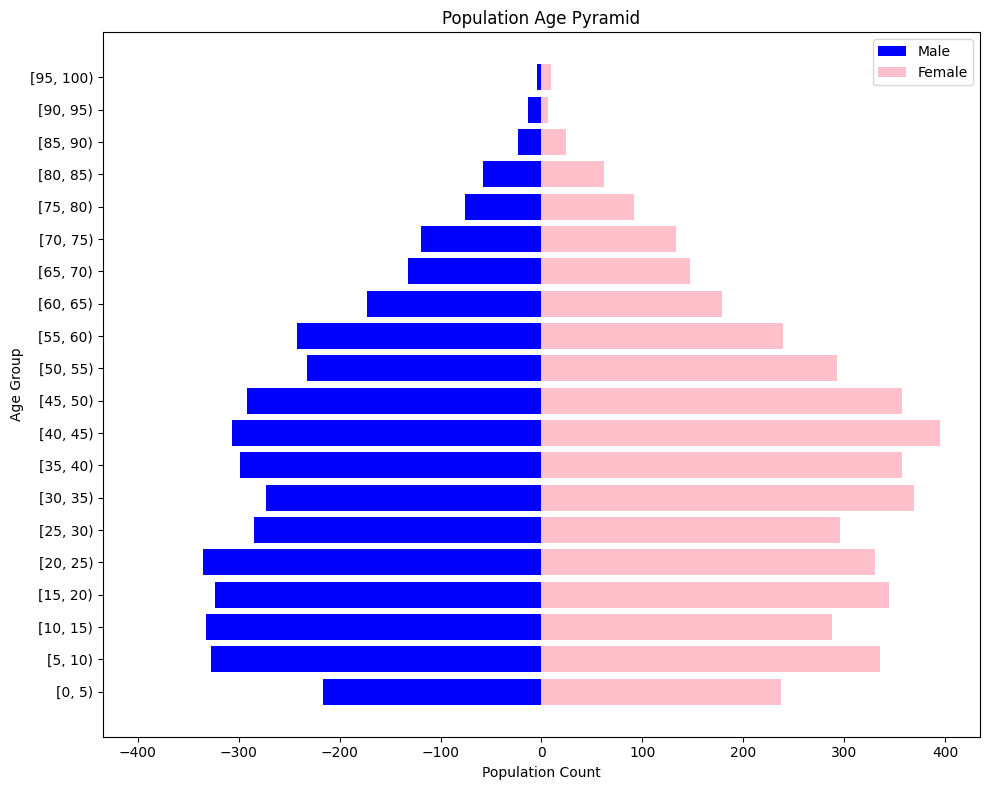

In [355]:

# This Ensures gender categories are consistent
df['Gender'] = df['Gender'].str.lower()

# Bin the ages into groups
bins = range(0, 101, 5)  # Age groups from 0 to 100 in 5-year intervals
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, right=False)

# Group the data by AgeGroup and Gender
age_gender = df.groupby(['AgeGroup', 'Gender']).size().unstack(fill_value=0)

# Prepare data for pyramid (negative for males)
age_gender['male'] = -1 * age_gender.get('male', 0)  # Negate male counts
age_gender['female'] = age_gender.get('female', 0)  # Female counts as positive

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Bar plots for males and females
ax.barh(age_gender.index.astype(str), age_gender['male'], color='blue', label='Male')
ax.barh(age_gender.index.astype(str), age_gender['female'], color='pink', label='Female')

# Adding  labels and titles
ax.set_xlabel('Population Count')
ax.set_ylabel('Age Group')
ax.set_title('Population Age Pyramid')
ax.legend()

# This Tweak the x-axis to center around 0
max_count = max(abs(age_gender['male']).max(), age_gender['female'].max())
ax.set_xlim(-max_count * 1.1, max_count * 1.1)

plt.tight_layout()
plt.savefig('Age Pyramid')
plt.show()


## Percentage of population that is unemployed

In [378]:
# Define unemployed labels
unemployed_labels = ['Unemployed']

# Total rows in the Occupation column (excluding NaN values)
total_occupations = df['Occupation'].notna().sum()

# Count rows that meet unemployment conditions
unemployed_count = df['Occupation'].isin(unemployed_labels).sum()

# this Calculates unemployment percentage
unemployment_percent = (unemployed_count / total_occupations) * 100

# Displays the result
print(f"Unemployment Percentage: {unemployment_percent:.2f}%")


Unemployment Percentage: 6.20%


## PLot to show Unemployment by age group so as to see what group are most likely to be unemployed

C:\Users\USER\AppData\Local\Temp\ipykernel_14712\792934381.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unemployment_rates = df.groupby('Agegrouping')['Unemployed'].mean() * 100
C:\Users\USER\AppData\Local\Temp\ipykernel_14712\792934381.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unemployment_rates.index, y=unemployment_rates.values, palette='Blues_d')


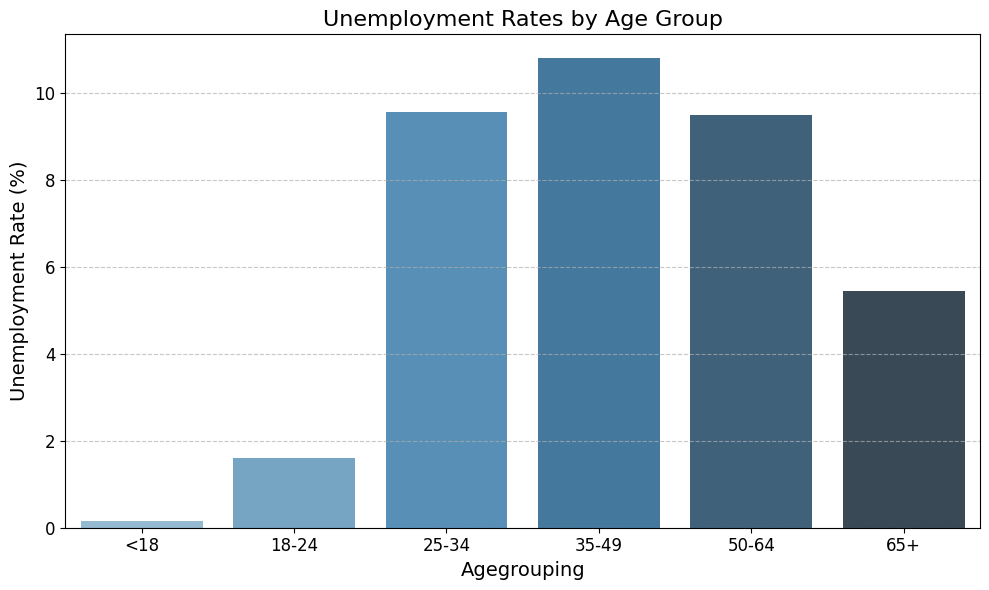

In [357]:
df['Unemployed'] = df['Occupation'] == 'Unemployed'

# Create age bins for better analysis
bins = [0, 18, 25, 35, 50, 65, 100]  # Adjust age bins as needed
labels = ['<18', '18-24', '25-34', '35-49', '50-64', '65+']
df['Agegrouping'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Calculate unemployment rates per age group
unemployment_rates = df.groupby('Agegrouping')['Unemployed'].mean() * 100

# Plots unemployment rates by age group
plt.figure(figsize=(10, 6))
sns.barplot(x=unemployment_rates.index, y=unemployment_rates.values, palette='Blues_d')
plt.title('Unemployment Rates by Age Group', fontsize=16)
plt.xlabel('Agegrouping', fontsize=14)
plt.ylabel('Unemployment Rate (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Unemployment rate by Age Group')
plt.show()

## This view Religion against different age groups to show which religions are growing or shrinking and which is becoming more popular

C:\Users\USER\AppData\Local\Temp\ipykernel_14712\1059754936.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  religion_age = df.groupby(['Religion', 'Agegrouping']).size().unstack(fill_value=0)


Religion Distribution by Agegrouping:
Agegrouping  0-18  19-25  26-35  36-45  46-55  56-65  65+
Religion                                                 
Christian    1001    436    484    712    662    526  525
Hindu          13     11     25      8      6      2    7
Muslim         23     19     45     12     14      5    8
Other        1039    525    669    626    492    300  358


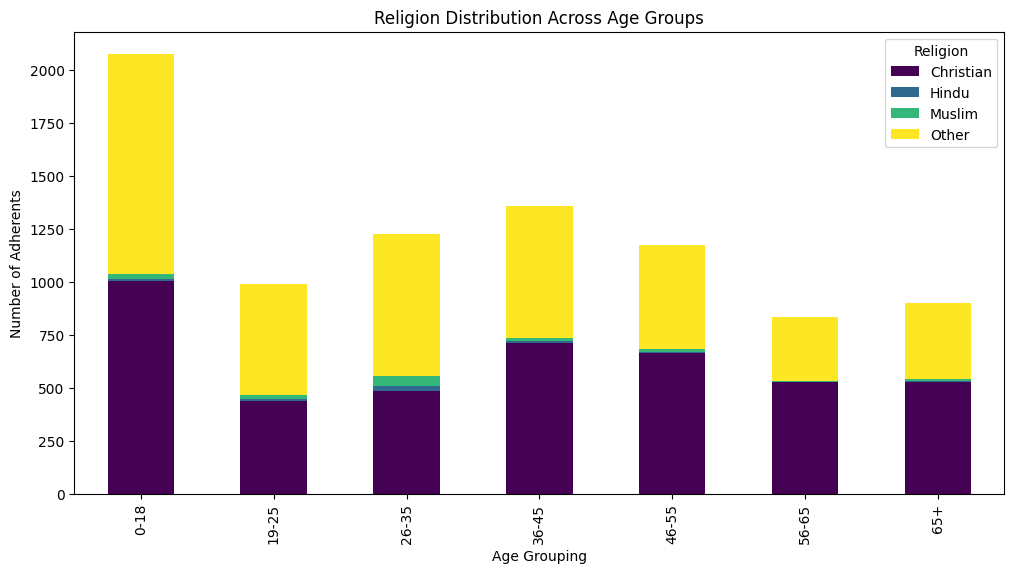

In [359]:

# i define age bins and labels
age_bins = [0, 18, 25, 35, 45, 55, 65, 100]
age_labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+']

# Creates 'Agegrouping' column
df['Agegrouping'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# Group 'Religion' by age group
religion_age = df.groupby(['Religion', 'Agegrouping']).size().unstack(fill_value=0)

print("Religion Distribution by Agegrouping:")
print(religion_age)

# Plot religion distribution across age groups
plt.figure(figsize=(12, 6))
religion_age.T.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Religion Distribution Across Age Groups')
plt.xlabel('Age Grouping')
plt.ylabel('Number of Adherents')
plt.legend(title='Religion')

# Save the plot
plt.savefig('Religion_Distribution.png', bbox_inches='tight')
plt.show()


In [381]:
# Defines unemployed labels
labels = ['Other']

# Total rows in the Occupation column (excluding NaN values)
total = df['Religion'].notna().sum()

# Count rows that meet unemployment conditions
count = df['Religion'].isin(labels).sum()

# Calculate unemployment percentage
percent = (count / total) * 100

# Display the result
print(f"Percentage: {percent:.2f}%")


Percentage: 46.90%


## Distribution of Religion

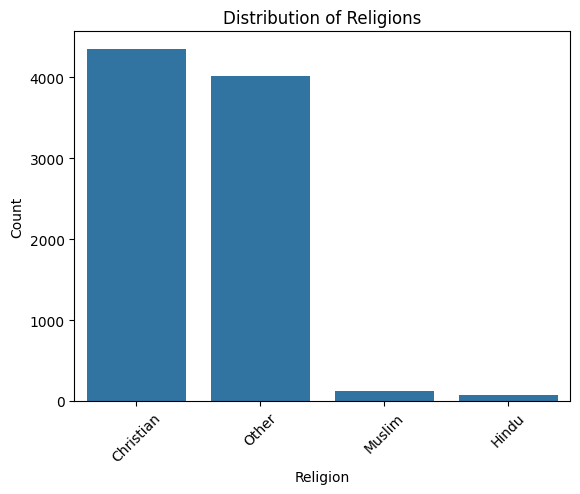

In [361]:
# Count the frequency of each religion
religion_counts = df['Religion'].value_counts()

# Create a bar plot
sns.barplot(x=religion_counts.index, y=religion_counts.values)
plt.xlabel('Religion')
plt.ylabel('Count')
plt.title('Distribution of Religions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

## Views "Other" religions to see its growth and show deviation from the traditional religions

C:\Users\USER\AppData\Local\Temp\ipykernel_14712\3151795377.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minority_religions['Agegrouping'] = pd.cut(minority_religions['Age'], bins=age_bins, labels=age_labels, right=False)
C:\Users\USER\AppData\Local\Temp\ipykernel_14712\3151795377.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  religion_age_group = minority_religions.groupby(['Religion', 'Agegrouping']).size().unstack(fill_value=0)


Minority Religions by Age Group:
Agegrouping  0-18  19-25  26-35  36-45  46-55  56-65  65+
Religion                                                 
Hindu          13     11     25      8      6      2    7
Muslim         23     19     45     12     14      5    8
Other        1039    525    669    626    492    300  358


<Figure size 1200x700 with 0 Axes>

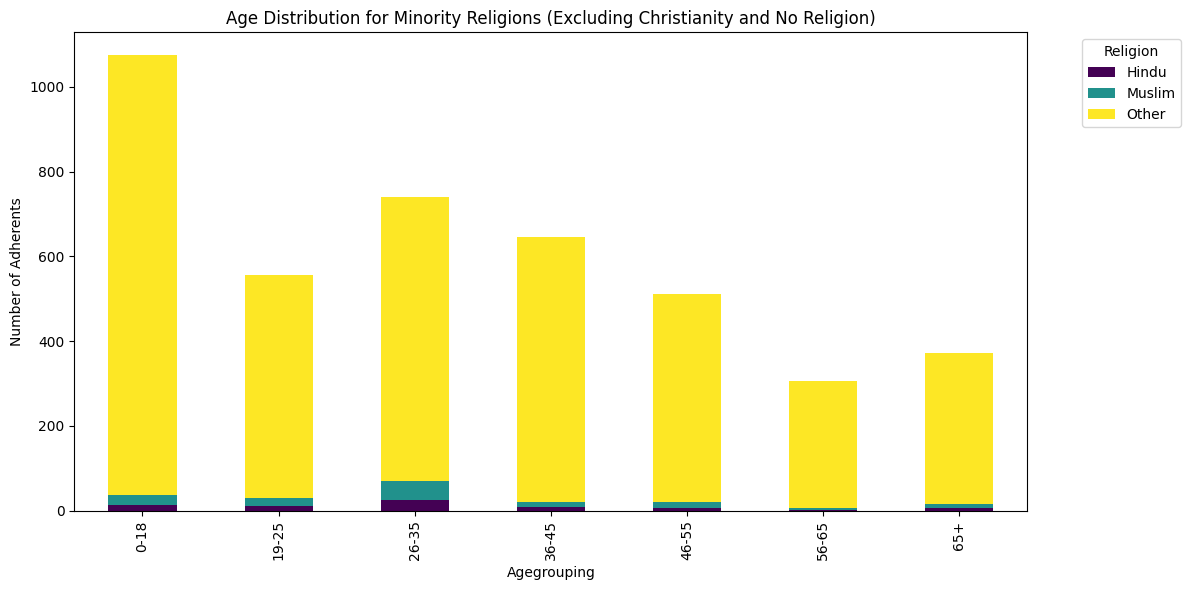

In [362]:
# Exclude Christianity and No Religion
minority_religions = df[~df['Religion'].isin(['Christian', 'No Religion'])]

# Define Age Bins
age_bins = [0, 18, 25, 35, 45, 55, 65, 100]
age_labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+']

# Create Age Group Column
minority_religions['Agegrouping'] = pd.cut(minority_religions['Age'], bins=age_bins, labels=age_labels, right=False)

# Group by Religion and Age Group
religion_age_group = minority_religions.groupby(['Religion', 'Agegrouping']).size().unstack(fill_value=0)

# Display Table
print("Minority Religions by Age Group:")
print(religion_age_group)

# Plot the Data (Stacked Bar Plot)
plt.figure(figsize=(12, 7))
religion_age_group.T.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))

# Customize the Plot
plt.title('Age Distribution for Minority Religions (Excluding Christianity and No Religion)')
plt.xlabel('Agegrouping')
plt.ylabel('Number of Adherents')
plt.legend(title='Religion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Shows The Distribution of Marital status

In [364]:
# Count the number of people in each Marital Status category
marital_status_counts = df['Marital Status'].value_counts(normalize=True) * 100

# Format the percentages to two decimal places
marital_status_counts = marital_status_counts.round(2)

# Display the results
print("Proportion of Marital Status in the Population (%):")
print(marital_status_counts)


Proportion of Marital Status in the Population (%):
Marital Status
Single            35.12
Married           28.40
Not Applicable    24.23
Divorced           8.35
Widowed            3.91
Name: proportion, dtype: float64


C:\Users\USER\AppData\Local\Temp\ipykernel_14712\3842087180.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=marital_status_counts.index, y=marital_status_counts.values, palette='viridis')


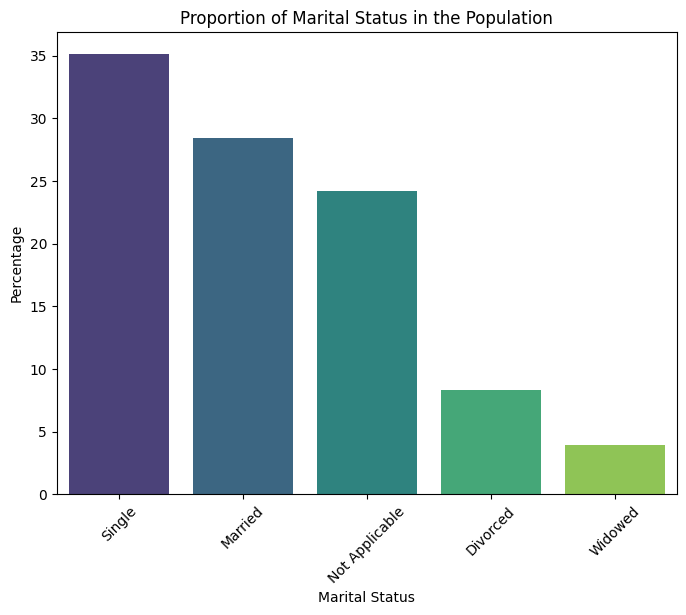

In [326]:
# Bar plot of marital status
plt.figure(figsize=(8, 6))
sns.barplot(x=marital_status_counts.index, y=marital_status_counts.values, palette='viridis')
plt.title('Proportion of Marital Status in the Population')
plt.ylabel('Percentage')
plt.xlabel('Marital Status')
plt.xticks(rotation=45)
plt.savefig('Marital status proportion.png')
plt.show()


Married vs Divorced Breakdown:
Marital Status
Married     28.40
Divorced     8.35
Name: proportion, dtype: float64


C:\Users\USER\AppData\Local\Temp\ipykernel_14712\3484526750.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=married_divorced.index, y=married_divorced.values, palette='muted')


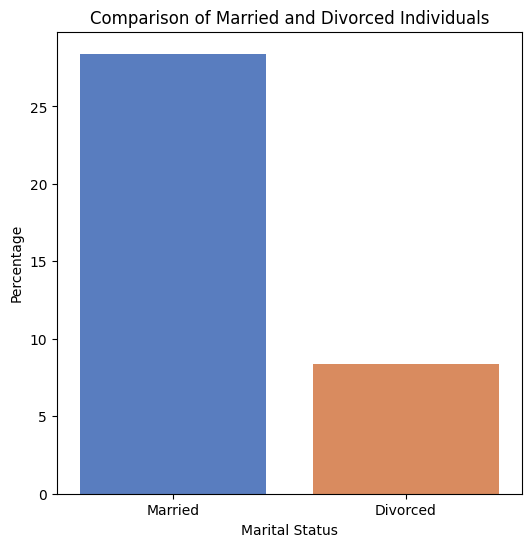

In [372]:
# Filter Married and Divorced counts
married_divorced = marital_status_counts[['Married', 'Divorced']]

# Display
print("Married vs Divorced Breakdown:")
print(married_divorced)

# Plot Married vs Divorced
plt.figure(figsize=(6, 6))
sns.barplot(x=married_divorced.index, y=married_divorced.values, palette='muted')
plt.title('Comparison of Married and Divorced Individuals')
plt.ylabel('Percentage')
plt.xlabel('Marital Status')
plt.savefig('Marital and divorce')
plt.show()


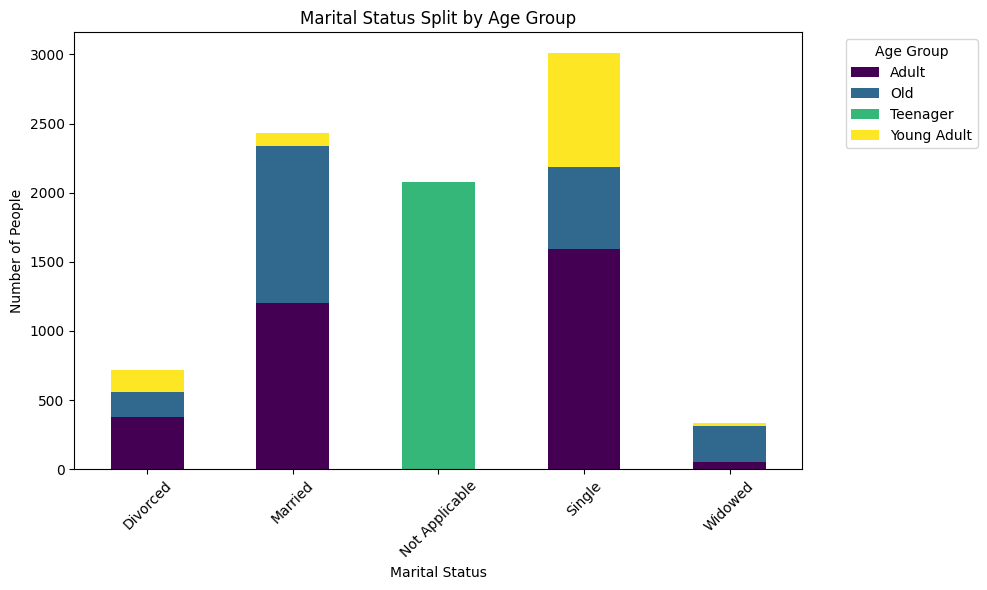

In [371]:
# Group the data to get counts of Age Group within each Marital Status
marital_age_group = df.groupby(['Marital Status', 'Age Group']).size().unstack(fill_value=0)

# Plot the data as a stacked bar plot
ax = marital_age_group.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 6), 
    colormap='viridis'
)

# Customize the plot
plt.title('Marital Status Split by Age Group')
plt.xlabel('Marital Status')
plt.ylabel('Number of People')
plt.xticks(rotation=45)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Marital status by Age Group')
plt.show()


['Married' 'Single' nan 'Divorced' 'Widowed']
Marriage Rate: 28.40%
Divorce Rate (Population): 8.35%
Divorce Rate (Ever Married): 20.53%


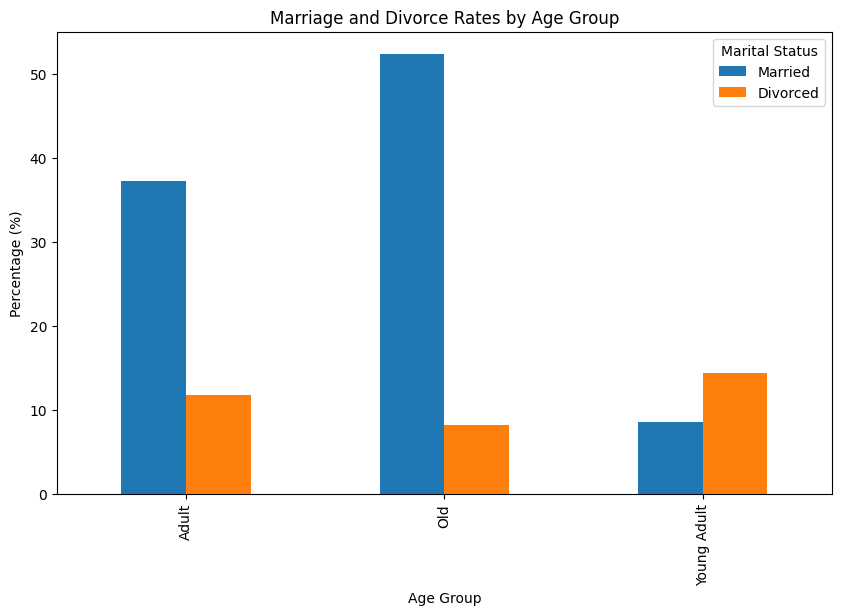

In [374]:
# Marriage and Divorce Rate per Age Group
# Inspect unique values in 'Marital Status'
print(df['Marital Status'].unique())

# Clean and normalize 'Marital Status'
status_mapping = {
    'Married': 'Married',
    'Divorced': 'Divorced',
    'Single': 'Single',
    'Widowed': 'Widowed',
    'Separated': 'Separated'
    # Add any additional mappings based on your dataset
}
df['Marital Status'] = df['Marital Status'].map(status_mapping)

# Calculate total individuals and marital counts
total_population = len(df)
married_count = (df['Marital Status'] == 'Married').sum()
divorced_count = (df['Marital Status'] == 'Divorced').sum()
ever_married_count = df['Marital Status'].isin(['Married', 'Divorced', 'Widowed']).sum()

# Calculate rates
marriage_rate = (married_count / total_population) * 100
divorce_rate_pop = (divorced_count / total_population) * 100
divorce_rate_married = (divorced_count / ever_married_count) * 100

print(f"Marriage Rate: {marriage_rate:.2f}%")
print(f"Divorce Rate (Population): {divorce_rate_pop:.2f}%")
print(f"Divorce Rate (Ever Married): {divorce_rate_married:.2f}%")

# Group by age group
age_group_stats = df.groupby('Age Group')['Marital Status'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot results
age_group_stats[['Married', 'Divorced']].plot(kind='bar', figsize=(10, 6))
plt.title('Marriage and Divorce Rates by Age Group')
plt.ylabel('Percentage (%)')
plt.xlabel('Age Group')
plt.legend(title='Marital Status')
plt.savefig('Mariage and  divorce specific by agegroup')
plt.show()


## Plot and hypothesis testing to show occupancy rates and states

Occupancy per House:
               Street  House Number  Occupancy
0         Adams Rocks             1          1
1     Anglia Barracks             1          2
2          Aries Lane             1          1
3          Aries Lane             2          2
4          Aries Lane             3          2
...               ...           ...        ...
2910    Winter Unions            15          3
2911    Winter Unions            16          4
2912    Winter Unions            17          4
2913    Winter Unions            18          4
2914   Yellow Mansion             1          3

[2915 rows x 3 columns]

Average Household Size: 2.36

Houses Classified by Occupancy Status:
               Street  House Number  Occupancy       Status
0         Adams Rocks             1          1    Underused
1     Anglia Barracks             1          2       Normal
2          Aries Lane             1          1    Underused
3          Aries Lane             2          2       Normal
4          Aries Lan

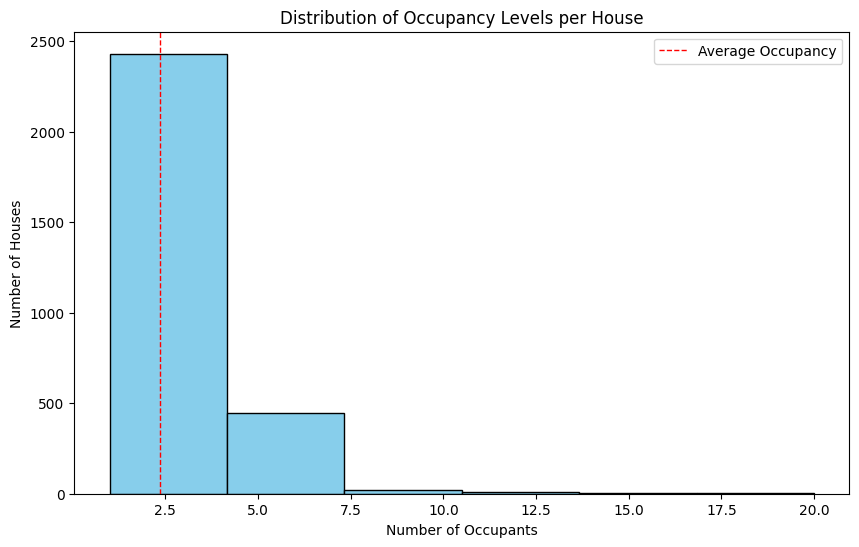


Hypothesis Test for Average Household Size:
T-Statistic: 17.1756
P-Value: 0.0000
Result: Reject the null hypothesis. The average household size significantly differs from 2.36.

Summary of Occupancy Status:
Status
Overcrowded    1517
Normal          702
Underused       696
Name: count, dtype: int64


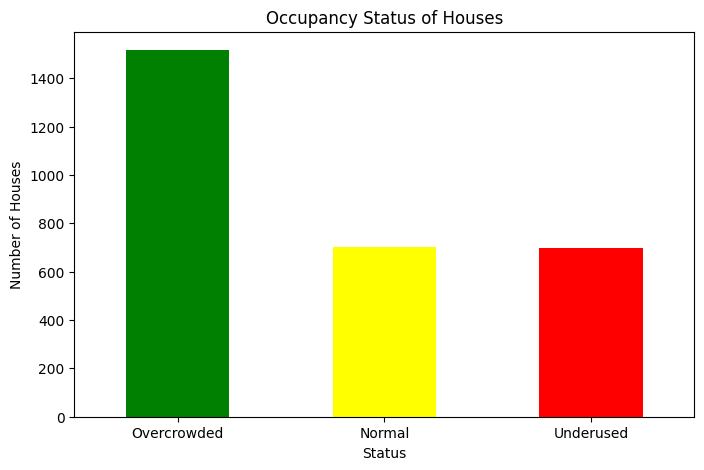

In [383]:

# i Grouped the data by Street and House Number, then count the number of occupants per house
occupancy = df.groupby(['Street', 'House Number']).size().reset_index(name='Occupancy')

# Display the grouped data
print("Occupancy per House:")
print(occupancy)

# Calculate the average household size (benchmark)
average_occupancy = 2.36
print(f"\nAverage Household Size: {average_occupancy:.2f}")

# Classify houses as underused, normal, or overcrowded
def occupancy_status(x):
    if x < average_occupancy * 0.75:
        return 'Underused'
    elif x > average_occupancy * 1.25:
        return 'Overcrowded'
    else:
        return 'Normal'

occupancy['Status'] = occupancy['Occupancy'].apply(occupancy_status)

# Display the classification
print("\nHouses Classified by Occupancy Status:")
print(occupancy)

# Plot the distribution of occupancy levels
plt.figure(figsize=(10, 6))
plt.hist(occupancy['Occupancy'], bins=6, color='skyblue', edgecolor='black')
plt.axvline(average_occupancy, color='red', linestyle='dashed', linewidth=1, label='Average Occupancy')
plt.title('Distribution of Occupancy Levels per House')
plt.xlabel('Number of Occupants')
plt.ylabel('Number of Houses')
plt.legend()
plt.savefig('Occupancy numbers')
plt.show()

# Hypothesis Test: Is the average occupancy rate equal to 2.36?
# H0: The mean occupancy rate = 2.36 (null hypothesis)
# H1: The mean occupancy rate ≠ 2.36 (alternative hypothesis)
t_statistic, p_value = ttest_1samp(occupancy['Occupancy'], popmean=average_occupancy)

# Print results
print("\nHypothesis Test for Average Household Size:")
print(f"T-Statistic: {t_statistic:.4f}")
print(f"P-Value: {p_value:.4f}")

# Decision based on significance level (alpha = 0.05)
alpha = 0.05
if p_value < alpha:
    print("Result: Reject the null hypothesis. The average household size significantly differs from 2.36.")
else:
    print("Result: Fail to reject the null hypothesis. No significant difference from 2.36.")

# Show counts of each status
status_counts = occupancy['Status'].value_counts()
print("\nSummary of Occupancy Status:")
print(status_counts)

# Optional: Visualize occupancy status using a bar plot
plt.figure(figsize=(8, 5))
status_counts.plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Occupancy Status of Houses')
plt.xlabel('Status')
plt.ylabel('Number of Houses')
plt.xticks(rotation=0)
plt.savefig('Occupancy ratio')
plt.show()


## Making a list of potential commuter occupations and determining the percentage of the population who are commuters. this tells us how important a train station and good roads are

In [389]:

# List of commuter occupations
commuter_occupations = [
    "Investment Analyst", "Chief Financial Officer", "Insurance Risk Surveyor",
    "Engineer, Manufacturing", "Product Manager", "Art Therapist",
    "Programmer Applications", "Multimedia Specialist", "Scientist, Research (Life Sciences)",
    "Site Engineer", "Bonds Trader", "Risk Analyst", "Adult Education",
    "Warehouse Manager", "Health and Safety Adviser", "Health and Safety Inspector",
    "Charity Fundraiser", "Waste Management Officer", "Engineer, Building Services"
    "Outdoor Activities/Education Manager", "Audiological Scientist", "Insurance Broker",
    "Retail Manager", "Geographical Information Systems Officer", "Teacher, Early Years/Pre-School",
    "Environmental Consultant", "Data Processing Manager", "Medical Technical Officer",
    "Communications Engineer", "Claims Inspector/Assessor", "Environmental Health Practitioner",
    "Scientist, Audiological", "Printmaker", "Psychologist, Occupational", "Administrator",
    "Engineer, Biomedical", "Designer, Furniture", "Planning and Development Surveyor",
    "Scientific Laboratory Technician", "Animal Technologist", "Logistics and Distribution Manager",
    "Sales Professional, IT", "Health Promotion Specialist", "Pensions Consultant", "Associate Professor",
    "Accounting Technician", "Dentist", "Chiropodist", "Toxicologist", "Trade Union Research Officer",
    "Sports Administrator", "Accountant, Chartered Certified", "Sports Development Officer",
    "Astronomer", "Barrister's Clerk", "Education Officer, Environmental",
    "Careers Adviser", "Student",
    "Embryologist, clinical", "Physiological scientist", "Research scientist (physical sciences)",
    "Scientist, physiological", "Engineer, biomedical", "Biomedical scientist", "Psychologist, educational",
    "Lecturer, higher education", "Lecturer, further education", "Science writer",
    "Engineer, civil (consulting)", "Engineer, chemical", "Engineer, technical sales",
    "Engineer, aeronautical", "Surveyor, land/geomatics",
    "Surveyor, minerals", "Engineer, manufacturing systems", "Engineer, electrical",
    "Geoscientist", "Geophysicist/field seismologist", "Engineer, mining", "Geochemist",
    "Engineer, environmental", "Marine biologist", "Oceanographer", "Geneticist, molecular",
    "Plant breeder/geneticist", "Biological scientist", "Technologist, laboratory",
    "Medical laboratory scientific officer", "Higher education careers adviser",
    "PhD Student", "Research officer, government", "Research scientist (medical)",
    "Research scientist (life sciences)", "Research scientist (physical sciences)",
    "Research scientist (maths)", "Educational psychologist",
    "Clinical research associate", "Psychologist, educational", "Lecturer, further education",
    "Teacher, adult education", "Higher education lecturer", "Academic librarian",
    "English as a foreign language teacher", "Learning mentor",
    "Science writer", "Lecturer, primary school teacher", "Philosophy lecturer", "History lecturer"
]

# Filter dataset to include only those with occupations in the commuter list
commuters = df[df['Occupation'].isin(commuter_occupations)]
student_count = df[df['Occupation'] == 'University Student'].shape[0]

# Count the number of commuters
num_commuters = commuters.shape[0]

# Count the total population
total_population = df.shape[0]

# Calculate the percentage of commuters
percentage_commuters = (num_commuters / total_population) * 100
percentage_university_students = (student_count / total_population) * 100
# Print the result
print("Number of University Students:", student_count)
print(f"Percentage of University Students: {percentage_university_students:.2f}%")
print(f"Number of commuters: {num_commuters}")
print(f"Total population: {total_population}")
print(f"Percentage of commuters: {percentage_commuters:.2f}%")


Number of University Students: 565
Percentage of University Students: 6.59%
Number of commuters: 2040
Total population: 8568
Percentage of commuters: 23.81%


## Plotting Birthrate for fertile groups

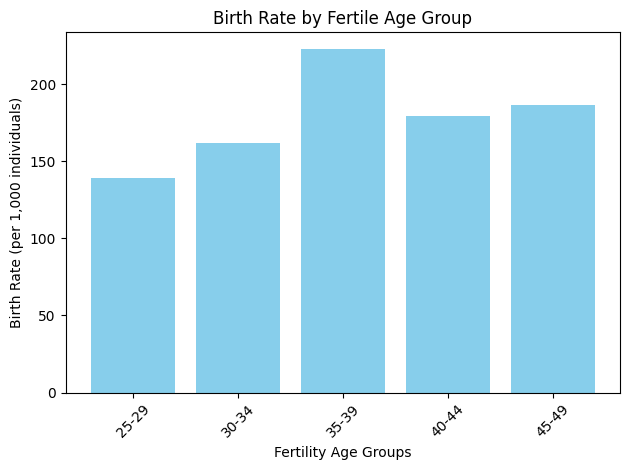

In [303]:
# Birth rate by fertile age group
# Defining the age groups for fertile individuals and corresponding child ages
fertile_groups = [(25, 29), (30, 34), (35, 39), (40, 44), (45, 49)]
child_ages = [0, 4, 8, 12, 16]  # Ages of children corresponding to fertile groups

# DataFrame assumed to be named df and already loaded
birth_rates = []

for (fertile_min, fertile_max), child_age in zip(fertile_groups, child_ages):
    # Filter fertile individuals within the age group
    fertile_group = df[(df['Age'] >= fertile_min) & (df['Age'] <= fertile_max)]
    
    # Count children of the specific age corresponding to the group
    children_count = len(df[df['Age'] == child_age])
    
    # Calculate the birth rate: (children / fertile individuals) * 1000
    birth_rate = (children_count / len(fertile_group)) * 1000 if len(fertile_group) > 0 else 0
    birth_rates.append(birth_rate)

# Prepare data for the plot
fertile_labels = [f"{min_age}-{max_age}" for min_age, max_age in fertile_groups]

# Plotting the birth rates
plt.bar(fertile_labels, birth_rates, color='skyblue')
plt.title('Birth Rate by Fertile Age Group')
plt.xlabel('Fertility Age Groups')
plt.ylabel('Birth Rate (per 1,000 individuals)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Plots the death rate for older group of the population

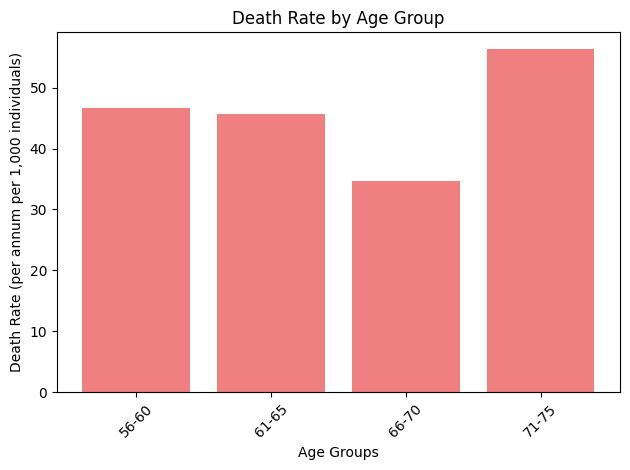

In [304]:
# Death rate per age group
# Defining the older age groups for calculating death rates
age_groups = [(56, 60), (61, 65), (66, 70), (71, 75), (76, 80)]
death_rates = []

# Iterate through age groups to calculate deaths
for i in range(len(age_groups) - 1):
    # Current age group
    current_group_min, current_group_max = age_groups[i]
    # Next age group
    next_group_min, next_group_max = age_groups[i + 1]

    # Filter individuals in the current and next groups
    current_group = df[(df['Age'] >= current_group_min) & (df['Age'] <= current_group_max)]
    next_group = df[(df['Age'] >= next_group_min) & (df['Age'] <= next_group_max)]

    # Calculate the number of people in each group
    current_group_count = len(current_group)
    next_group_count = len(next_group)

    # Calculate number of deaths
    deaths = current_group_count - next_group_count if current_group_count > next_group_count else 0

    # Calculate death rate per annum: (deaths / total population in current group) / 5 * 1000
    death_rate = (deaths / current_group_count / 5 * 1000) if current_group_count > 0 else 0
    death_rates.append(death_rate)

# Prepare data for the plot
age_group_labels = [f"{min_age}-{max_age}" for min_age, max_age in age_groups[:-1]]

# Plotting the death rates
plt.bar(age_group_labels, death_rates, color='lightcoral')
plt.title('Death Rate by Age Group')
plt.xlabel('Age Groups')
plt.ylabel('Death Rate (per annum per 1,000 individuals)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Birthrate for entire population per 100,000

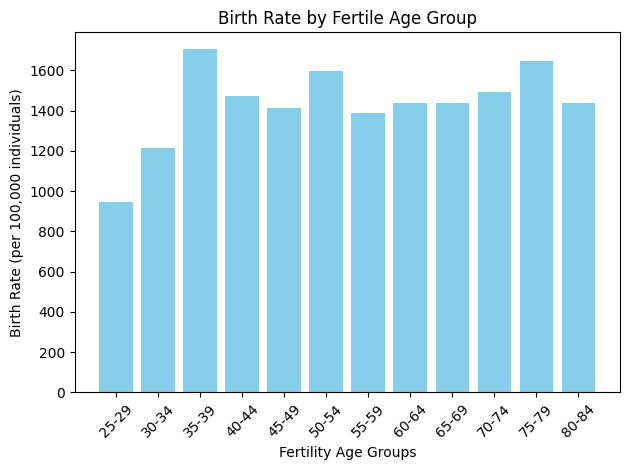

Total Birth Rate: 17180.21


In [395]:
# Define the age groups for fertile individuals and corresponding child ages
fertile_groups = [(25, 29), (30, 34), (35, 39), (40, 44), (45, 49), (50, 54), (55, 59),
                  (60, 64), (65, 69), (70, 74), (75, 79), (80, 84)]

# Ages of children corresponding to fertile groups
child_ages = [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44]

# Initialize variables for loop
birth_rates = []
fertile_population = 0
children = 0

# Total population for scaling birth rates
total_population = len(df)

# Loop to calculate birth rate for each age group
for (fertile_min, fertile_max), child_age in zip(fertile_groups, child_ages):
    # Filter fertile individuals within the age group
    fertile_group = df[(df['Age'] >= fertile_min) & (df['Age'] <= fertile_max) & (df['Gender'] == 'Female')]

    # Count children of the specific age corresponding to the group
    children_count = len(df[df['Age'] == child_age])

    # Calculate the birth rate: use total population as denominator for consistency
    birth_rate = (children_count / total_population) * 100000

    # Append results to lists and update totals
    birth_rates.append(birth_rate)
    children += children_count
    fertile_population += len(fertile_group)

# Prepare data for the plot
fertile_labels = [f"{min_age}-{max_age}" for min_age, max_age in fertile_groups]

# Calculate the total birth rate (per 100,000 individuals)
total_birth_rate = (children / total_population) * 100000

# Plot birth rates
plt.bar(fertile_labels, birth_rates, color='skyblue')
plt.title('Birth Rate by Fertile Age Group')
plt.xlabel('Fertility Age Groups')
plt.ylabel('Birth Rate (per 100,000 individuals)')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.savefig('Birthrate')
plt.show()

# Print total birth rate across all fertile age groups
print(f'Total Birth Rate: {total_birth_rate:.2f}')


## Death rate for entire population per 100,000

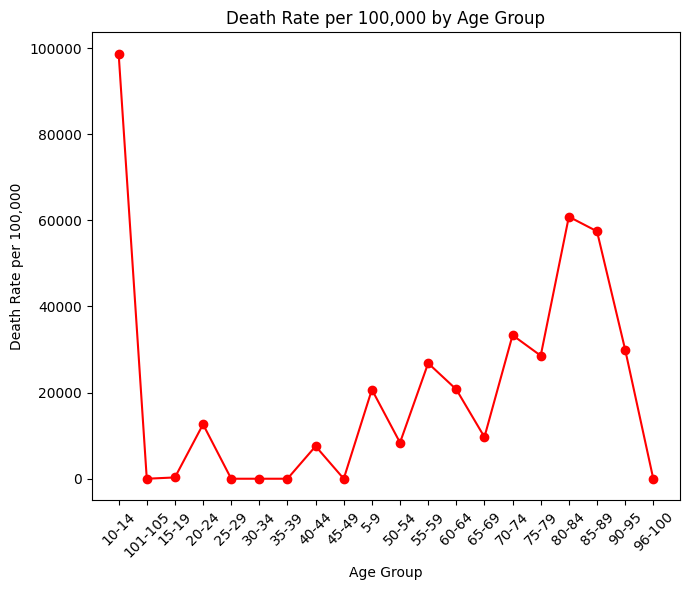

   Age Group  Population  Deaths  Death Rate per 100,000
0      10-14         620     612            98709.677419
1    101-105           8       0                0.000000
2      15-19         667       2              299.850075
3      20-24         665      84            12631.578947
4      25-29         581       0                0.000000
5      30-34         642       0                0.000000
6      35-39         656       0                0.000000
7      40-44         702      53             7549.857550
8      45-49         649       0                0.000000
9        5-9         662     137            20694.864048
10     50-54         525      44             8380.952381
11     55-59         481     129            26819.126819
12     60-64         352      73            20738.636364
13     65-69         279      27             9677.419355
14     70-74         252      84            33333.333333
15     75-79         168      48            28571.428571
16     80-84         120      7

In [396]:
# Death Rate per 100,000 by Age Group

# Define age groups
age_groups = [(5, 9), (10, 14), (15, 19), (20, 24), (25, 29), (30, 34),
              (35, 39), (40, 44), (45, 49), (50, 54), (55, 59), (60, 64), (65, 69),
              (70, 74), (75, 79), (80, 84), (85, 89), (90, 95), (96, 100), (101, 105)]


# Function to assign age group
def assign_age_group(age):
    for start, end in age_groups:
        if start <= age <= end:
            return f'{start}-{end}'


# Apply the function to assign age groups to the dataset
df['Age Group'] = df['Age'].apply(assign_age_group)

# Calculate the population for each age group
age_group_population = df.groupby('Age Group').size()

# Calculate death counts (assuming differences between adjacent age groups)
death_counts = []
age_group_list = age_group_population.index.tolist()
pop_values = age_group_population.values.tolist()

for i in range(len(pop_values)):
    if i < len(pop_values) - 1:
        death_counts.append(max(0, pop_values[i] - pop_values[i + 1]))
    else:
        death_counts.append(0)  # Assuming no deaths after the last age group

# Create a DataFrame for age group populations and deaths
death_data = pd.DataFrame({
    'Age Group': age_group_population.index,
    'Population': age_group_population.values,
    'Deaths': death_counts
})

# Calculate the death rate per 100,000 for each group
death_data['Death Rate per 100,000'] = (death_data['Deaths'] / death_data['Population']) * 100000

# Calculate the death rate across all age groups
total_death_rate = (death_data['Deaths'].sum() / death_data['Population'].sum()) * 100000

# Plot the death rate per 100,000
plt.figure(figsize=(7, 6))
plt.plot(death_data['Age Group'], death_data['Death Rate per 100,000'], marker='o', color='r')
plt.title('Death Rate per 100,000 by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Death Rate per 100,000')
plt.xticks(rotation=45)
plt.tight_layout()

# Save figure (optional)
# plt.savefig('Death_Rate')
plt.savefig('Deathrate')

plt.show()

# Display the death data table
print(death_data)
print(f'\nTotal Death Rate: {total_death_rate:.2f}')

## Status of the Population, Determining if the Population is shrinking or Growing 

In [393]:
# Divorced young adults
divorced_young_adults = len(df[(df['Marital Status'] == 'Divorced') & (df['Age'].between(18, 35))])

# Unemployed young adults
unemployed_young_adults = len(df[(df['Occupation'] == 'Unemployed') & (df['Age'].between(18, 35))])

# Lodgers and visitors who are students and under 25
lodgers_visitors_students = len(df[(df['Relationship to Head of House'].isin(['Lodger', 'Visitor'])) 
                                  & (df['Age'] < 25)])

# Retired individuals who are lodgers or visitors
retired_lodgers_visitors = len(df[(df['Occupation'].str.contains('Retired')) & 
                                  (df['Relationship to Head of House'].isin(['Lodger', 'Visitor']))])

# Total potential emigrants
potential_emigrants = divorced_young_adults + unemployed_young_adults + lodgers_visitors_students

# Immigrants: Lodgers and visitors in commuter_occupations or retired
potential_immigrants = len(df[(df['Relationship to Head of House'].isin(['Lodger', 'Visitor'])) 
                             & (df['Occupation'].isin(commuter_occupations))]) + retired_lodgers_visitors

# Total population
total_population = len(df)

# Immigration rate per 100,000
immigration_rate = (potential_immigrants / total_population) * 100000

# Emigration rate per 100,000
emigration_rate = (potential_emigrants / total_population) * 100000

# Birth and death rates (assume these are pre-calculated)
birth_rate = total_birth_rate
death_rate = total_death_rate

# Calculate number of births, deaths, immigrants, and emigrants
births = (birth_rate / 100000) * total_population
deaths = (death_rate / 100000) * total_population
immigrants = (immigration_rate / 100000) * total_population
emigrants = (emigration_rate / 100000) * total_population

# Net population change
net_population_change = births - deaths + immigrants - emigrants

# Predict population for the next year
predicted_population = total_population + net_population_change

# Output results
print(f"Current Population: {total_population}")
print(f"Immigration Rate per 100,000: {immigration_rate:.2f}")
print(f"Emigration Rate per 100,000: {emigration_rate:.2f}")
print(f"Birth Rate per 100,000: {birth_rate:.2f}")
print(f"Death Rate per 100,000: {death_rate:.2f}")
print(f"Predicted Population Change: {net_population_change:.2f}")
print(f"Predicted Population for Next Year: {predicted_population:.2f}")

# Check for if the population is expected to grow or shrink
if net_population_change > 0:
    print("The population is predicted to grow.")
else:
    print("The population is predicted to shrink.")


Current Population: 8568
Immigration Rate per 100,000: 396.83
Emigration Rate per 100,000: 6045.75
Birth Rate per 100,000: 17180.21
Death Rate per 100,000: 17250.31
Predicted Population Change: -490.01
Predicted Population for Next Year: 8077.99
The population is predicted to shrink.
